In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,RocCurveDisplay,classification_report,PrecisionRecallDisplay,ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,load_digits,load_wine,load_breast_cancer
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
iris=load_iris(return_X_y=True, as_frame=True)
df_iris=pd.concat([iris[0],iris[1]],axis=1)
digits=load_digits(return_X_y=True, as_frame=True)
df_digits=pd.concat([digits[0],digits[1]],axis=1)
wine=load_wine(return_X_y=True, as_frame=True)
df_wine=pd.concat([wine[0],wine[1]],axis=1)
breast_cancer=load_breast_cancer(return_X_y=True, as_frame=True)
df_breast_cancer=pd.concat([breast_cancer[0],breast_cancer[1]],axis=1)

In [3]:
df_iris.target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [4]:
df_digits.target.value_counts()

target
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

In [5]:
df_wine.target.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [6]:
df_breast_cancer.target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [7]:
#DOCUMENTACAO GERADA COM AI (validada por mim)
def metricas_clusterizacao(df, MAX_n_clusters):
    """
    Clusters a given dataframe, computes internal validation metrics, and returns these metrics in a DataFrame.

    The function performs K-means clustering for a range of cluster numbers from 2 to MAX_n_clusters.
    For each number of clusters, it calculates:
    - Within-cluster sum of squares (WSS)
    - Silhouette score
    - Centroid coordinates

    The results are compiled into a DataFrame containing columns for the cluster count, WSS distances, silhouette scores, and centroids.

    Parameters:
    df : DataFrame
        Input data for clustering.
    MAX_n_clusters : int
        Maximum number of clusters to consider.

    Returns:
    DataFrame
        A DataFrame containing the number of clusters, WSS distances, silhouette scores, and centroids for each cluster number.
    """
    distancias_wss=[]
    silhouette_scores=[]
    k=[]
    centroids=[] #Essa info talvez seja útil.
    for i in range(2,MAX_n_clusters+1):
        kmeans=KMeans(n_clusters=i, random_state=42,init='k-means++')
        kmeans.fit(df)
        distancias_wss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df,kmeans.labels_))
        k.append(i)
        centroids.append(kmeans.cluster_centers_)        
    df_metricas=pd.DataFrame({'clusters':k,'distancias_wss':distancias_wss,'silhouette_score':silhouette_scores,'centroids':centroids})
    return df_metricas

def plot_cotovelo_silhueta(distancias_wss, silhouette_scores, Ks):
    """
    Generates and displays two plots: the Silhouette Score and the Within-Cluster Sum of Squares (WSS)
    based on the provided metrics for different numbers of clusters.

    Parameters:
    - distancias_wss (list): List of WSS distances for each number of clusters.
    - silhouette_scores (list): List of Silhouette Scores for each number of clusters.
    - Ks (list): List of the number of clusters used to calculate the metrics.

    Returns:
    - None
    """
    plt.plot(Ks, silhouette_scores,marker='o')
    plt.title('Score Silhueta')
    plt.xlabel('Numero de clusters')
    plt.ylabel('Score Silhueta')
    plt.show()
    plt.plot(Ks, distancias_wss,marker='o')
    plt.title('Método do "cotovelo"')
    plt.xlabel('Numero de clusters')
    plt.ylabel('Distâncias WSS')
    plt.show()
    return None
        
def clusterizacao_feature_extra(df,n_clusters,scaler,test_or_train):
    """
    Clusters the input DataFrame and appends distance features to each cluster centroid.

    Args:
        df (pandas.DataFrame): The input DataFrame to be clustered.
        n_clusters (int): The number of clusters to form.
        scaler: The scaler to be used for feature scaling. If None, a new StandardScaler is created.
        test_or_train (str): Identifies whether the DataFrame is for training or testing ('test' or 'train').

    Returns:
        tuple: A tuple containing the modified DataFrame with additional distance features and the scaler used.

    Raises:
        Exception: If the 'test_or_train' parameter is not provided or not 'test' or 'train'.
    """
    if scaler is None:
        scaler=StandardScaler()
    kmeans=KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
    kmeans.fit(df)
    df_distancias=pd.DataFrame()
    centroids={k:v for k,v in enumerate(kmeans.cluster_centers_)}
    for k,v in centroids.items():
        lista_centroids=[centroids[k] for i in df.index]
        distancias_temp=paired_euclidean_distances(df,lista_centroids).reshape(-1,1)
        df_distancias[f'Distancia_ao_Centroid_{k}']=pd.Series(distancias_temp.flatten(), index=df.index)
    if test_or_train=='test':
        df_distancias=pd.DataFrame(scaler.transform(df_distancias),columns=df_distancias.columns)
    elif test_or_train=='train':
        df_distancias=pd.DataFrame(scaler.fit_transform(df_distancias),columns=df_distancias.columns)    
    else:
        raise Exception('O PARAMETRO test_or_train NAO FOI PASSADO CORRETAMENTE')
    df=pd.concat([df,df_distancias],axis='columns')
    return df,scaler

def escolhe_svm(x_train,y_train):
    """
         Selects and trains an SVM model using grid search with cross-validation to find the best hyperparameters based on training data.

         Args:
             x_train (array-like or sparse matrix): The training input samples.
             y_train (array-like): The target values (class labels) as integers or strings.

         Returns:
             estimator: The best estimator found by the grid search.
    """
    svm=SVC()
    params={'kernel':['linear','poly','rbf','sigmoid'],'C':np.linspace(start=0.1,stop=3,num=5)}
    svm_gs=GridSearchCV(estimator=svm,param_grid=params,n_jobs=-1,cv=5,scoring='f1_macro')
    svm_gs.fit(x_train,y_train)
    print(f'SVM - Parâmetros escolhidos (scoring f1_macro): {svm_gs.best_params_}')
    print(f'SVM - Melhor scoring f1_macro -> {svm_gs.best_score_}')
    return svm_gs.best_estimator_

def escolhe_random_forest(x_train,y_train):
    """
         def escolhe_random_forest(x_train, y_train):

         Perform a grid search to find the best hyperparameters for a RandomForestClassifier
         using cross-validation with a 5-fold split, and an accuracy scoring metric.

         Args:
         x_train: Training data features.
         y_train: Training data target labels.

         Returns:
         The best RandomForestClassifier model based on accuracy score after grid search.
    """
    rf=RandomForestClassifier()
    params={'criterion':['gini', "entropy", "log_loss"],'max_depth':[5,6,7]}
    rf_gs=GridSearchCV(estimator=rf,param_grid=params,n_jobs=-1,cv=5,scoring='f1_macro')
    rf_gs.fit(x_train,y_train)
    print(f'Random Forest - Parâmetros escolhidos (scoring f1_macro): {rf_gs.best_params_}')
    print(f'Random Forest - Melhor scoring f1_macro -> {rf_gs.best_score_}')
    return rf_gs.best_estimator_

def avalia_modelo(modelo,x_test,y_test,titulo):
    """
    Evaluates a given classification model using test data and displays several evaluation metrics.

    Parameters:
    modelo : The classifier model to evaluate.
    x_test : The input features of the test dataset.
    y_test : The true labels of the test dataset.
    titulo : A string title for the plots.

    Generates:
    Confusion matrix plot using the test data.
    ROC curve and Precision-Recall curve plots for binary classification problems.
    Classification report in the console showing precision, recall, and F1-score.

    Returns:
    None
    """
    y_pred=modelo.predict(x_test)    
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred,y_true=y_test,cmap='inferno')
    plt.title(titulo)
    try:
        RocCurveDisplay.from_predictions(y_pred=y_pred,y_true=y_test)
        plt.title(titulo)
        PrecisionRecallDisplay.from_predictions(y_pred=y_pred,y_true=y_test)
        plt.title(titulo)
    except ValueError:
        print('A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.\n')
    print(classification_report(y_true=y_test,y_pred=y_pred))
    return None

def treino_teste_scaled(features,target):
    """
    Splits the provided features and target into training and testing sets 
    and scales the feature sets using StandardScaler.

    Args:
        features (pd.DataFrame): DataFrame containing the feature data.
        target (pd.Series or np.ndarray): Array or Series containing the target data.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.Series or np.ndarray, pd.Series or np.ndarray]: 
        Scaled training feature set, scaled testing feature set, training target set, testing target set.
    """
    x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.3,random_state=42)
    scaler=StandardScaler()
    x_train_scaled=pd.DataFrame(scaler.fit_transform(x_train),columns=features.columns)
    x_test_scaled=pd.DataFrame(scaler.transform(x_test),columns=features.columns)
    return x_train_scaled,x_test_scaled,y_train,y_test

PASSO 1: Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

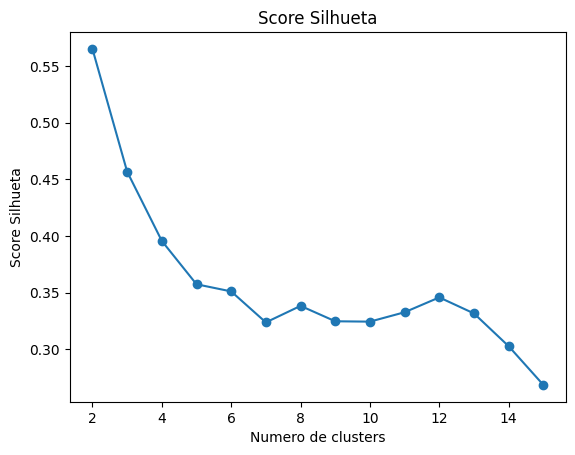

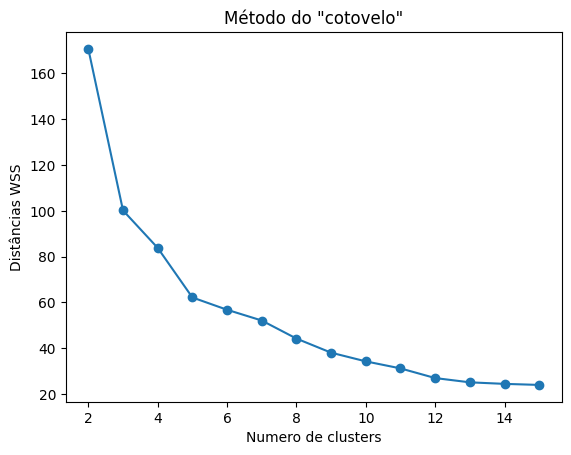

In [8]:
#IRIS
features_iris=df_iris.drop('target',axis=1)
target_iris=df_iris['target']
x_train_iris_scaled, x_test_iris_scaled, y_train_iris, y_test_iris = treino_teste_scaled(features_iris, target_iris)

df_metricas_iris=metricas_clusterizacao(x_train_iris_scaled,15)

plot_cotovelo_silhueta(df_metricas_iris['distancias_wss'],df_metricas_iris['silhouette_score'],df_metricas_iris['clusters'])

Para o dataset IRIS: Com o resultado dos gráficos, tomo K=3 por ter bom score silhueta e um "cotovelo". O fato de saber que só existem 3 itens no target também influenciou, já que essas classes devem estar bem delimitadas por 3 clusters.

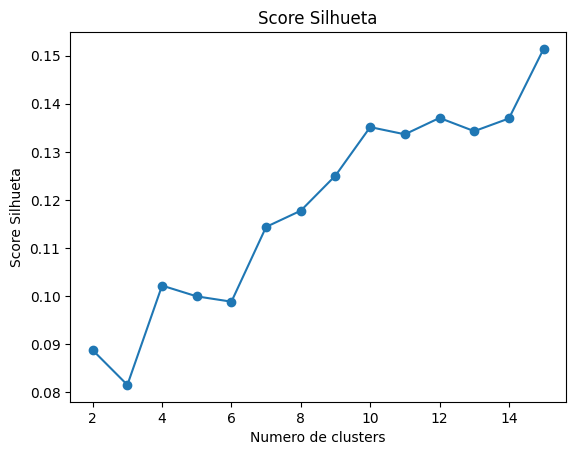

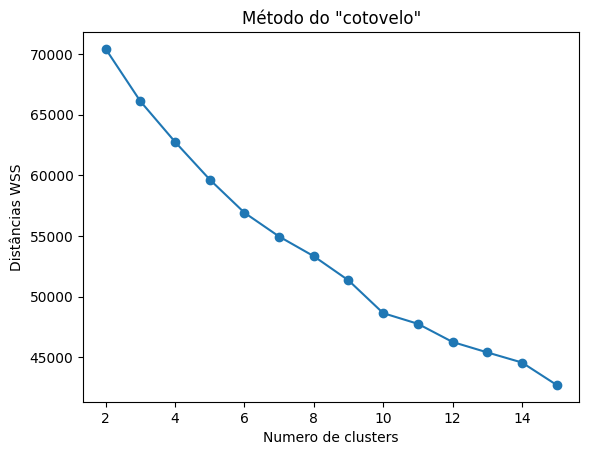

In [9]:
#DIGITS
features_digits=df_digits.drop('target',axis=1)
target_digits=df_digits['target']
x_train_digits_scaled, x_test_digits_scaled, y_train_digits, y_test_digits = treino_teste_scaled(features_digits, target_digits)
df_metricas_digits=metricas_clusterizacao(x_train_digits_scaled,15)

plot_cotovelo_silhueta(df_metricas_digits['distancias_wss'],df_metricas_digits['silhouette_score'],df_metricas_digits['clusters'])

Para o dataset DIGITS: Tomo K=4. Com um alto número de clusters, as features extras estavam piorando demais o resultado, ao ponto de deixar o modelo imprestável. Os gráficos mostram que os clusters não estão bem definidos (baixo silhueta), e acredito que as features extras estavam diminuindo a importância das features originais, confundindo o modelo. 

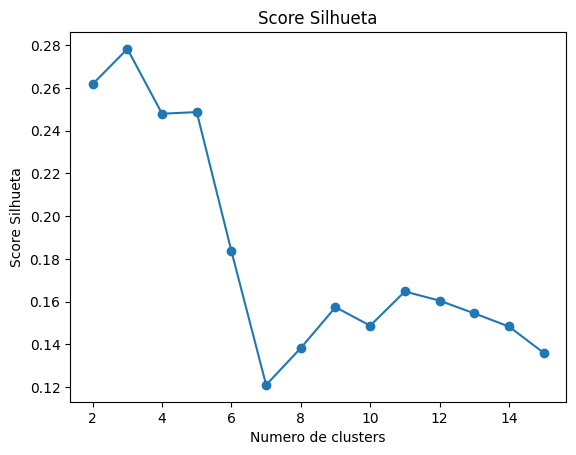

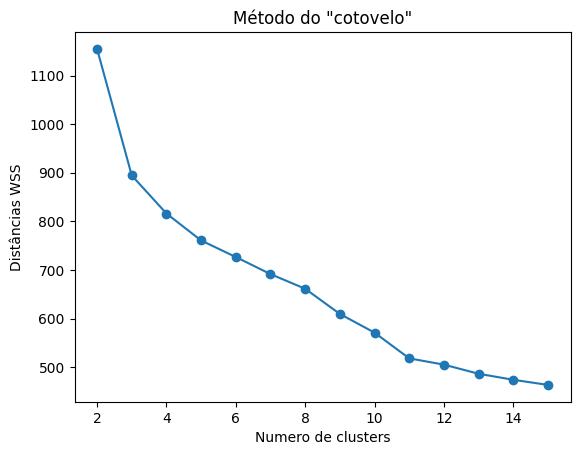

In [10]:
#WINE
features_wine=df_wine.drop('target',axis=1)
target_wine=df_wine['target']
x_train_wine_scaled, x_test_wine_scaled, y_train_wine, y_test_wine = treino_teste_scaled(features_wine, target_wine)
df_metricas_wine=metricas_clusterizacao(x_train_wine_scaled,15)

plot_cotovelo_silhueta(df_metricas_wine['distancias_wss'],df_metricas_wine['silhouette_score'],df_metricas_wine['clusters'])

Para o dataset WINE tomo K=3, por ter o maior índice silhueta, apresentar a maior queda nas distâncias internas dos clusters, e pelo fato de saber que só existem 3 targets possíveis, o que me leva a crer que os clusters devem estar bem definidos pelas suas características, cada um sendo uma das classes do target. Raciocínio similar ao feito no iris.

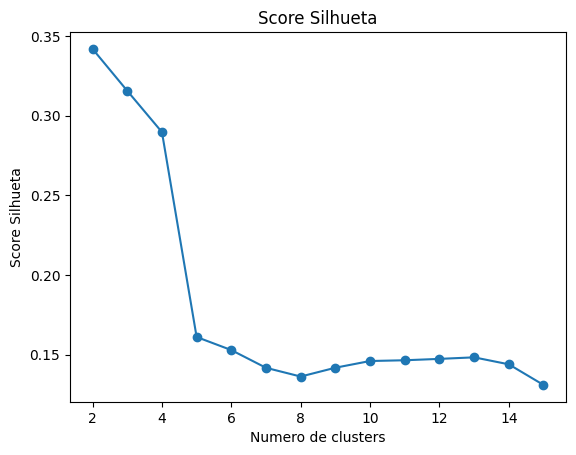

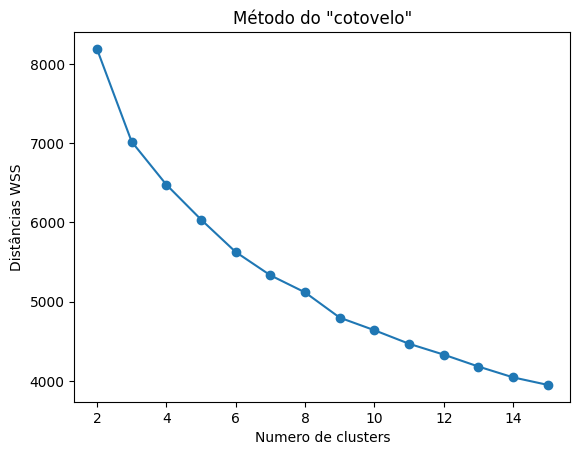

In [11]:
#BREAST_CANCER
features_breast_cancer=df_breast_cancer.drop('target',axis=1)
target_breast_cancer=df_breast_cancer['target']
x_train_breast_cancer_scaled, x_test_breast_cancer_scaled, y_train_breast_cancer, y_test_breast_cancer = treino_teste_scaled(features_breast_cancer, target_breast_cancer)
df_metricas_breast_cancer=metricas_clusterizacao(x_train_breast_cancer_scaled,15)

plot_cotovelo_silhueta(df_metricas_breast_cancer['distancias_wss'],df_metricas_breast_cancer['silhouette_score'],df_metricas_breast_cancer['clusters'])

Para o dataset BREAST CANCER: tomo K=4 pois acima disso o índice silhueta cai muito, indicando que os clusters não tem boa definição.

PASSO 2: Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado, na esperança de melhorar as métricas

In [12]:
x_train_iris_scaled_clusterizado,scaler_iris=clusterizacao_feature_extra(df=x_train_iris_scaled,n_clusters=3,scaler=None,test_or_train='train')
x_train_digits_scaled_clusterizado,scaler_digits=clusterizacao_feature_extra(df=x_train_digits_scaled,n_clusters=4,scaler=None,test_or_train='train')
x_train_wine_scaled_clusterizado,scaler_wine=clusterizacao_feature_extra(df=x_train_wine_scaled,n_clusters=3,scaler=None,test_or_train='train')
x_train_breast_cancer_scaled_clusterizado,scaler_breast_cancer=clusterizacao_feature_extra(df=x_train_breast_cancer_scaled,n_clusters=4,scaler=None,test_or_train='train')

In [13]:
x_test_iris_scaled_clusterizado,scaler_iris=clusterizacao_feature_extra(df=x_test_iris_scaled,n_clusters=3,scaler=scaler_iris,test_or_train='test')
x_test_digits_scaled_clusterizado,scaler_digits=clusterizacao_feature_extra(df=x_test_digits_scaled,n_clusters=4,scaler=scaler_digits,test_or_train='test')
x_test_wine_scaled_clusterizado,scaler_wine=clusterizacao_feature_extra(df=x_test_wine_scaled,n_clusters=3,scaler=scaler_wine,test_or_train='test')
x_test_breast_cancer_scaled_clusterizado,scaler_breast_cancer=clusterizacao_feature_extra(df=x_test_breast_cancer_scaled,n_clusters=4,scaler=scaler_breast_cancer,test_or_train='test')

PASSO 3: Modelos de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Usando:
- Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.
- Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

In [14]:
melhor_svm_iris=escolhe_svm(x_train_iris_scaled_clusterizado,y_train_iris)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(0.825), 'kernel': 'linear'}
SVM - Melhor scoring f1_macro -> 0.9545745648686825


In [15]:
melhor_svm_digits=escolhe_svm(x_train_digits_scaled_clusterizado,y_train_digits)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(2.275), 'kernel': 'rbf'}
SVM - Melhor scoring f1_macro -> 0.9784600316398278


In [16]:
melhor_svm_wine=escolhe_svm(x_train_wine_scaled_clusterizado,y_train_wine)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(0.825), 'kernel': 'sigmoid'}
SVM - Melhor scoring f1_macro -> 0.9769973954494079


In [17]:
melhor_svm_breast_cancer=escolhe_svm(x_train_breast_cancer_scaled_clusterizado,y_train_breast_cancer)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(2.275), 'kernel': 'rbf'}
SVM - Melhor scoring f1_macro -> 0.9730528278381172


In [18]:
melhor_rf_escolhida_iris=escolhe_random_forest(x_train_iris_scaled_clusterizado,y_train_iris)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'gini', 'max_depth': 6}
Random Forest - Melhor scoring f1_macro -> 0.9456632909574086


In [19]:
melhor_rf_escolhida_digits=escolhe_random_forest(x_train_digits_scaled_clusterizado,y_train_digits)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'log_loss', 'max_depth': 7}
Random Forest - Melhor scoring f1_macro -> 0.9614796507067236


In [20]:
melhor_rf_escolhida_wine=escolhe_random_forest(x_train_wine_scaled_clusterizado,y_train_wine)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'gini', 'max_depth': 5}
Random Forest - Melhor scoring f1_macro -> 0.977046783625731


In [21]:
melhor_rf_escolhida_breast_cancer=escolhe_random_forest(x_train_breast_cancer_scaled_clusterizado,y_train_breast_cancer)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'log_loss', 'max_depth': 7}
Random Forest - Melhor scoring f1_macro -> 0.951368977229284


PASSO 4: Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precision, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


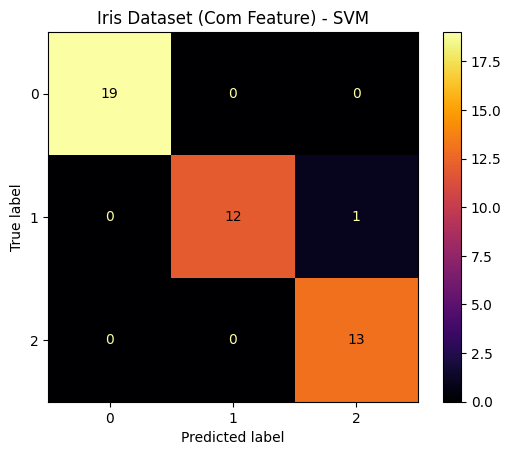

In [22]:
avalia_modelo(melhor_svm_iris,x_test_iris_scaled_clusterizado,y_test_iris,'Iris Dataset (Com Feature) - SVM')

A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        50
           2       0.94      1.00      0.97        47
           3       0.98      0.94      0.96        54
           4       0.98      1.00      0.99        60
           5       0.98      0.98      0.98        66
           6       0.96      1.00      0.98        53
           7       1.00      0.96      0.98        55
           8       0.95      0.95      0.95        43
           9       0.98      0.95      0.97        59

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


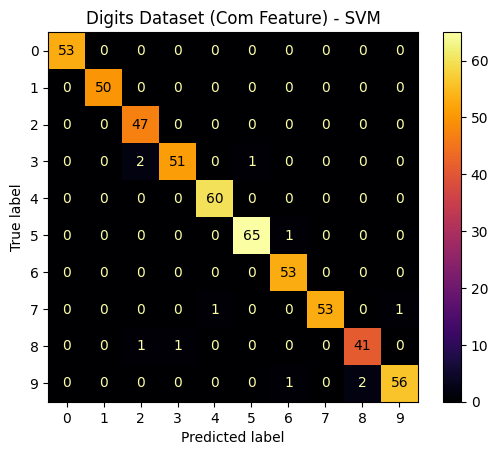

In [23]:
avalia_modelo(melhor_svm_digits,x_test_digits_scaled_clusterizado,y_test_digits,'Digits Dataset (Com Feature) - SVM')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



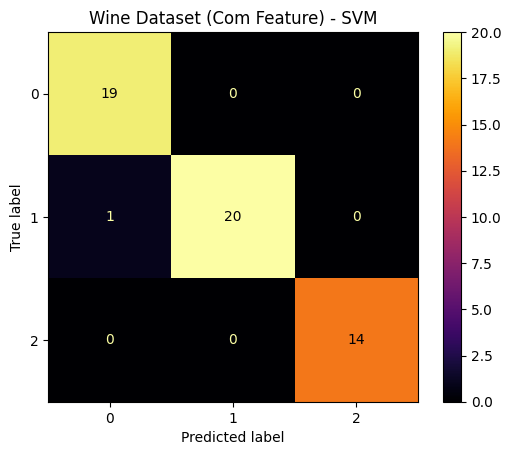

In [24]:
avalia_modelo(melhor_svm_wine,x_test_wine_scaled_clusterizado,y_test_wine,'Wine Dataset (Com Feature) - SVM')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.97      0.95        63
           1       0.98      0.95      0.97       108

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



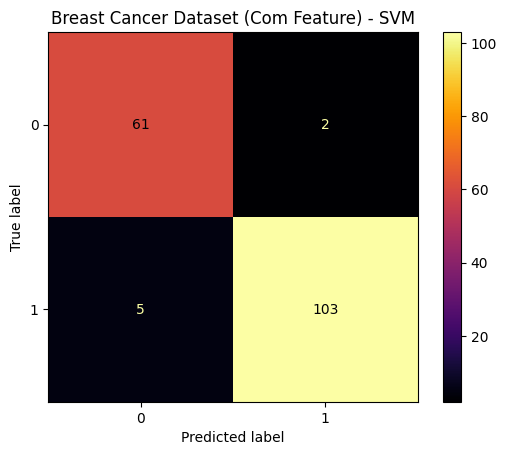

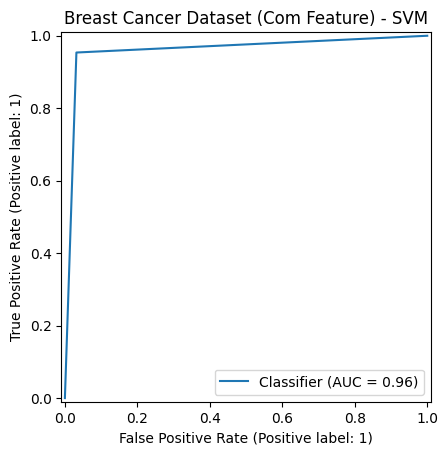

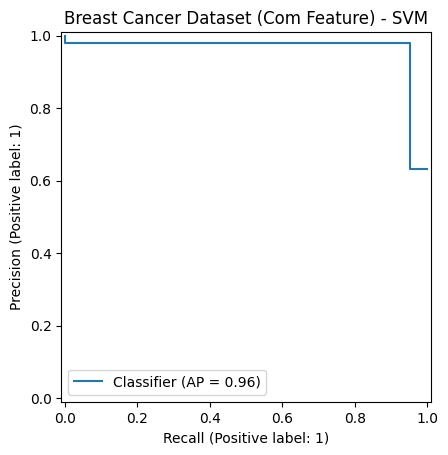

In [25]:
avalia_modelo(melhor_svm_breast_cancer,x_test_breast_cancer_scaled_clusterizado,y_test_breast_cancer,'Breast Cancer Dataset (Com Feature) - SVM')

In [26]:
x_test_digits_scaled_clusterizado


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,Distancia_ao_Centroid_0,Distancia_ao_Centroid_1,Distancia_ao_Centroid_2,Distancia_ao_Centroid_3
0,0.0,-0.351631,-1.079464,-1.113006,0.032749,-1.030913,-0.400396,-0.129943,-0.059636,-0.621944,...,-1.077192,-0.688142,0.434839,1.231819,0.709036,-0.191786,-0.142387,-0.085950,0.136549,-0.695312
1,0.0,-0.351631,1.198929,0.974780,-0.908177,-1.030913,-0.400396,-0.129943,-0.059636,1.216826,...,1.433490,0.896512,-0.182547,-0.987493,-0.505874,-0.191786,-0.860417,-0.839957,0.235672,-0.260897
2,0.0,-0.351631,0.577549,0.742804,0.032749,-0.312588,-0.400396,-0.129943,-0.059636,0.910364,...,1.433490,0.896512,0.640635,0.207521,-0.505874,-0.191786,-0.622035,-1.189273,0.568210,-0.114341
3,0.0,-0.351631,-0.665211,0.046875,0.032749,1.124061,2.259430,1.705318,-0.059636,-0.621944,...,-0.497804,0.670133,-1.828912,-1.158209,-0.505874,-0.191786,-0.112525,1.027025,0.829914,0.905376
4,0.0,1.836489,1.613182,0.974780,-0.437714,-1.030913,-0.400396,-0.129943,-0.059636,1.216826,...,1.819749,0.896512,0.846430,0.548954,-0.262892,-0.191786,0.000176,-0.222456,1.143571,0.345686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.0,-0.351631,-1.079464,-2.736840,-1.378640,1.662805,0.190676,-0.129943,-0.059636,-0.621944,...,-1.077192,-2.725555,-0.799934,0.207521,-0.505874,-0.191786,0.094982,0.836427,-0.615103,0.357194
536,0.0,-0.351631,0.784675,0.046875,0.738444,1.662805,0.190676,-0.129943,-0.059636,-0.315482,...,1.047231,-0.688142,-2.446298,-1.158209,-0.505874,-0.191786,-1.070328,0.198663,0.310621,0.221247
537,0.0,-0.351631,-0.043831,0.742804,0.032749,-0.851332,-0.400396,-0.129943,-0.059636,-0.621944,...,-0.111545,0.670133,-0.182547,-0.475344,-0.505874,-0.191786,-0.543636,-0.389272,-0.120131,-1.192298
538,0.0,-0.351631,0.991802,0.974780,0.738444,-1.030913,-0.400396,-0.129943,-0.059636,0.603903,...,1.240361,-0.235384,-2.446298,-1.158209,-0.505874,-0.191786,-0.747338,0.032198,0.571387,0.386877


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


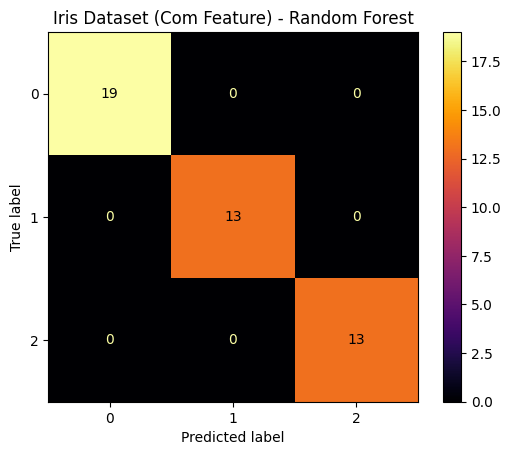

In [27]:
avalia_modelo(melhor_rf_escolhida_iris,x_test_iris_scaled_clusterizado,y_test_iris,'Iris Dataset (Com Feature) - Random Forest')

A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.94      0.96      0.95        50
           2       0.96      0.98      0.97        47
           3       1.00      0.93      0.96        54
           4       0.98      0.98      0.98        60
           5       0.94      0.97      0.96        66
           6       0.98      0.98      0.98        53
           7       0.93      0.98      0.96        55
           8       0.89      0.93      0.91        43
           9       0.98      0.90      0.94        59

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


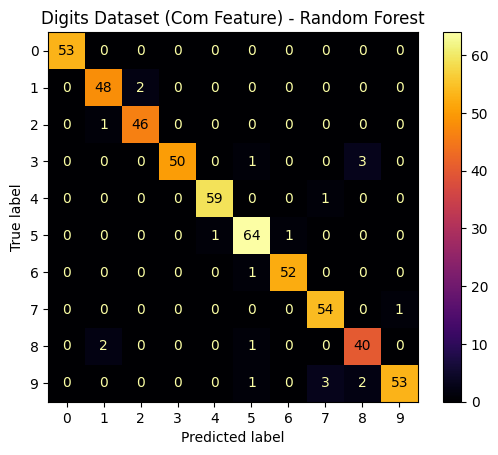

In [28]:
avalia_modelo(melhor_rf_escolhida_digits,x_test_digits_scaled_clusterizado,y_test_digits,'Digits Dataset (Com Feature) - Random Forest')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.87      0.95      0.91        21
           2       1.00      1.00      1.00        14

    accuracy                           0.93        54
   macro avg       0.94      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



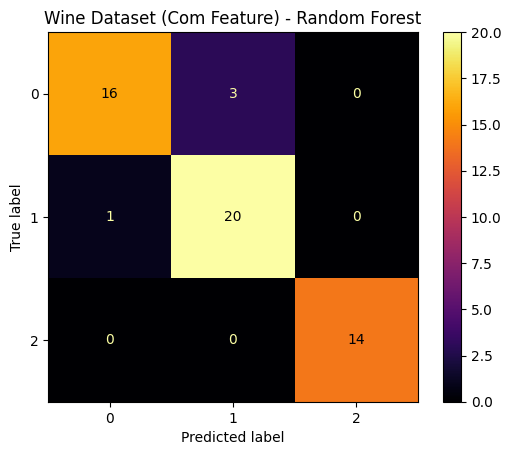

In [29]:
avalia_modelo(melhor_rf_escolhida_wine,x_test_wine_scaled_clusterizado,y_test_wine,'Wine Dataset (Com Feature) - Random Forest')

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


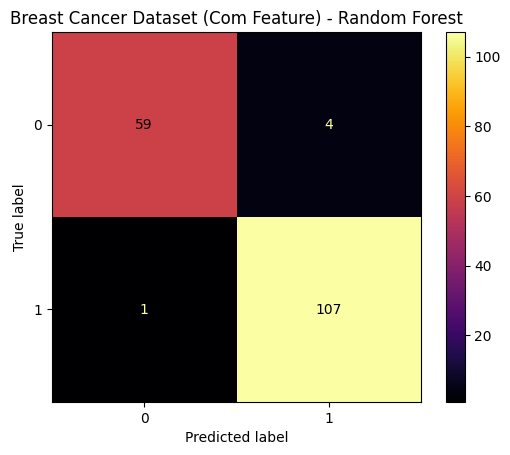

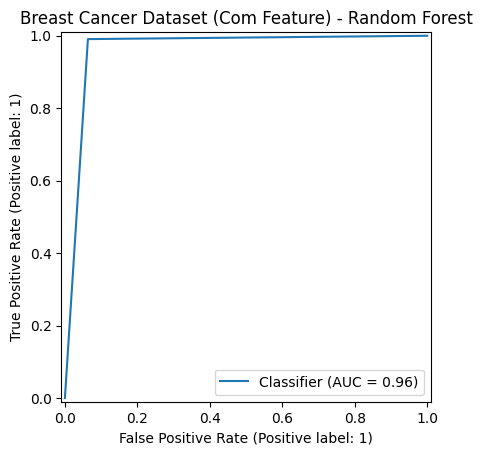

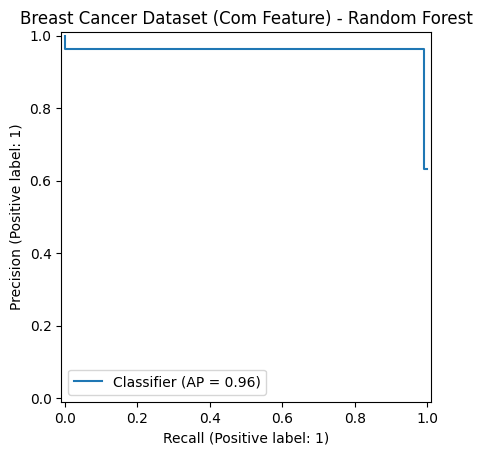

In [30]:
avalia_modelo(melhor_rf_escolhida_breast_cancer,x_test_breast_cancer_scaled_clusterizado,y_test_breast_cancer,'Breast Cancer Dataset (Com Feature) - Random Forest')

PASSO 5: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho, usando gráficos para ilustrar argumentos.

In [31]:
melhor_svm_iris_sem_feature=escolhe_svm(x_train_iris_scaled,y_train_iris)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(0.825), 'kernel': 'linear'}
SVM - Melhor scoring f1_macro -> 0.9545745648686825


In [32]:
melhor_svm_digits_sem_feature=escolhe_svm(x_train_digits_scaled,y_train_digits)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(2.275), 'kernel': 'rbf'}
SVM - Melhor scoring f1_macro -> 0.9784600316398278


In [33]:
melhor_svm_wine_sem_feature=escolhe_svm(x_train_wine_scaled,y_train_wine)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(0.825), 'kernel': 'linear'}
SVM - Melhor scoring f1_macro -> 0.984093567251462


In [34]:
melhor_svm_breast_cancer_sem_feature=escolhe_svm(x_train_breast_cancer_scaled,y_train_breast_cancer)

SVM - Parâmetros escolhidos (scoring f1_macro): {'C': np.float64(1.55), 'kernel': 'rbf'}
SVM - Melhor scoring f1_macro -> 0.9730528278381172


In [35]:
melhor_rf_iris_sem_feature=escolhe_random_forest(x_train_iris_scaled,y_train_iris)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'entropy', 'max_depth': 7}
Random Forest - Melhor scoring f1_macro -> 0.9544706600588955


In [36]:
melhor_rf_digits_sem_feature=escolhe_random_forest(x_train_digits_scaled,y_train_digits)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'entropy', 'max_depth': 7}
Random Forest - Melhor scoring f1_macro -> 0.9640860224724621


In [37]:
melhor_rf_wine_sem_feature=escolhe_random_forest(x_train_wine_scaled,y_train_wine)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'gini', 'max_depth': 5}
Random Forest - Melhor scoring f1_macro -> 0.9690608875128998


In [38]:
melhor_rf_breast_cancer_sem_feature=escolhe_random_forest(x_train_breast_cancer_scaled,y_train_breast_cancer)

Random Forest - Parâmetros escolhidos (scoring f1_macro): {'criterion': 'entropy', 'max_depth': 7}
Random Forest - Melhor scoring f1_macro -> 0.9596954251354687


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


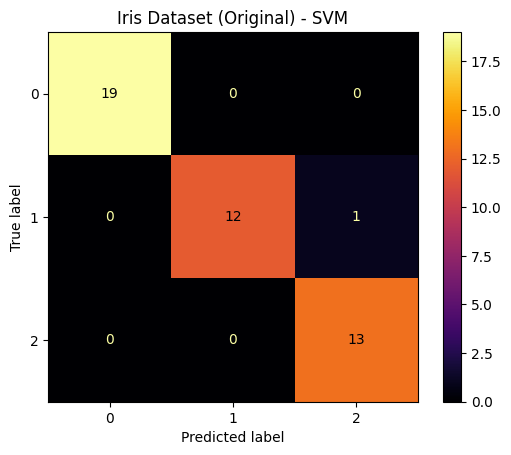

In [39]:
avalia_modelo(melhor_svm_iris_sem_feature,x_test_iris_scaled,y_test_iris,'Iris Dataset (Original) - SVM')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        50
           2       0.94      1.00      0.97        47
           3       0.98      0.94      0.96        54
           4       0.98      1.00      0.99        60
           5       0.99      1.00      0.99        66
           6       0.98      1.00      0.99        53
           7       1.00      0.96      0.98        55
           8       0.95      0.95      0.95        43
           9       0.98      0.95      0.97        59

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



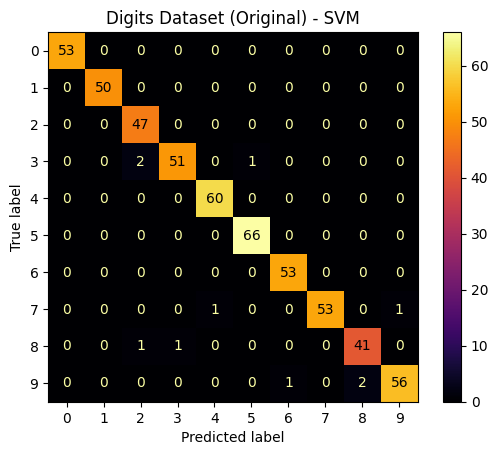

In [40]:
avalia_modelo(melhor_svm_digits_sem_feature,x_test_digits_scaled,y_test_digits,'Digits Dataset (Original) - SVM')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



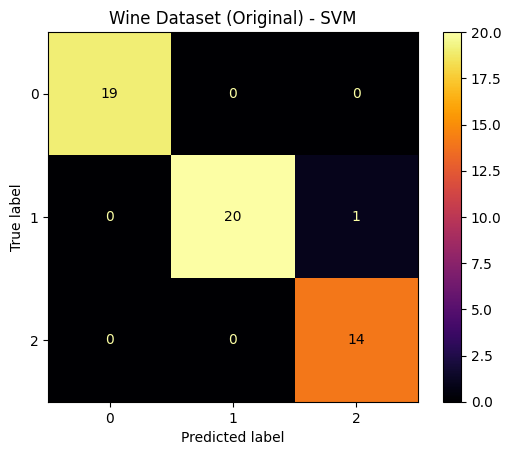

In [41]:
avalia_modelo(melhor_svm_wine_sem_feature,x_test_wine_scaled,y_test_wine,'Wine Dataset (Original) - SVM')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



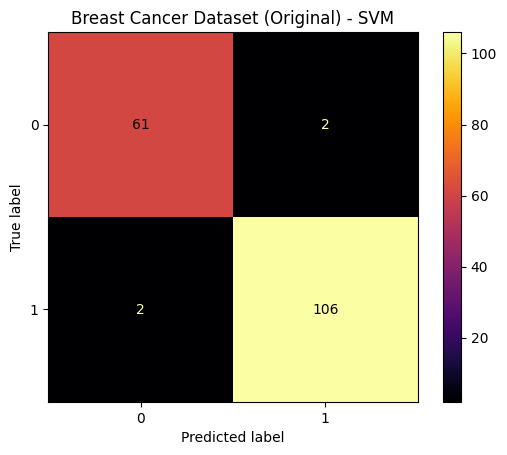

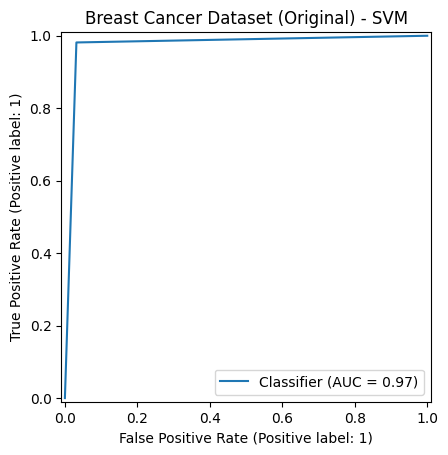

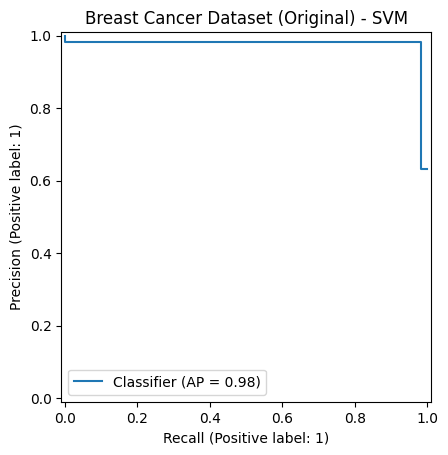

In [42]:
avalia_modelo(melhor_svm_breast_cancer_sem_feature,x_test_breast_cancer_scaled,y_test_breast_cancer,'Breast Cancer Dataset (Original) - SVM')

A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


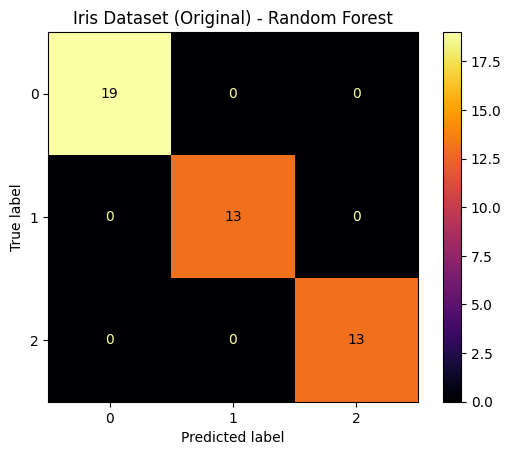

In [43]:
avalia_modelo(melhor_rf_iris_sem_feature,x_test_iris_scaled,y_test_iris,'Iris Dataset (Original) - Random Forest')

C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.96      0.94      0.95        50
           2       0.96      1.00      0.98        47
           3       1.00      0.93      0.96        54
           4       0.98      1.00      0.99        60
           5       0.95      0.95      0.95        66
           6       0.98      0.98      0.98        53
           7       0.96      0.98      0.97        55
           8       0.91      0.95      0.93        43
           9       0.96      0.93      0.95        59

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



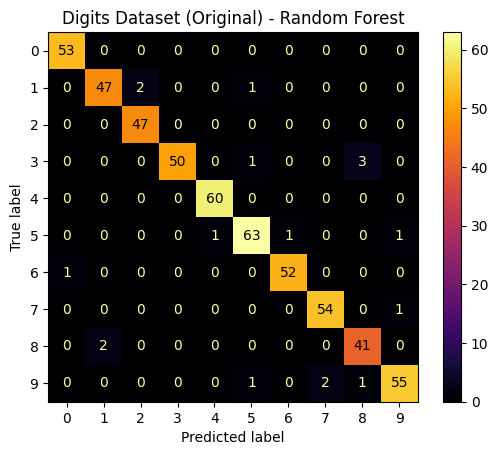

In [44]:
avalia_modelo(melhor_rf_digits_sem_feature,x_test_digits_scaled,y_test_digits,'Digits Dataset (Original) - Random Forest')

A curva ROC e Precision-Recall só podem ser plotadas para problemas binários de classificação.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        14

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


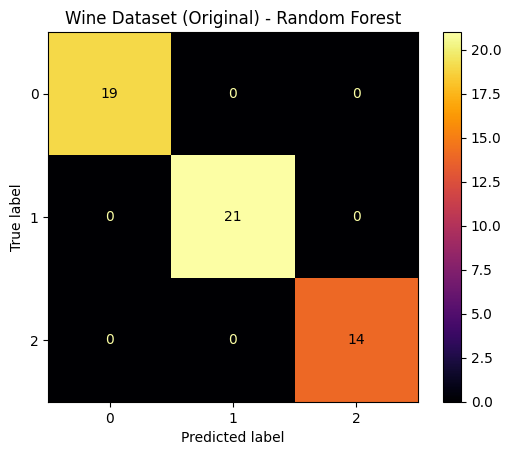

In [45]:
avalia_modelo(melhor_rf_wine_sem_feature,x_test_wine_scaled,y_test_wine,'Wine Dataset (Original) - Random Forest')

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



C:\Clube_Algoritmos\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


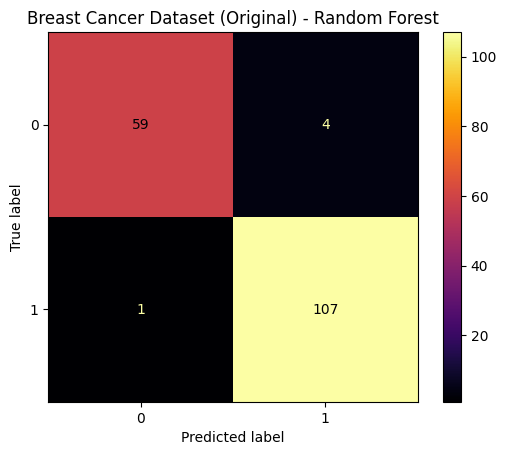

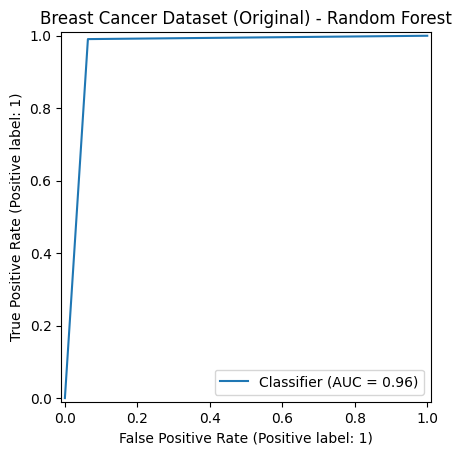

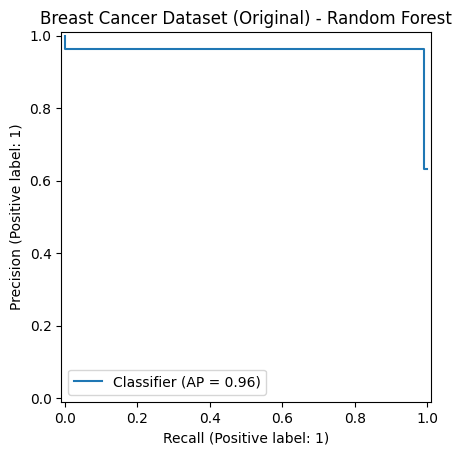

In [46]:
avalia_modelo(melhor_rf_breast_cancer_sem_feature,x_test_breast_cancer_scaled,y_test_breast_cancer,'Breast Cancer Dataset (Original) - Random Forest')